## Patches Extractor

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities_NOMXNET import *

/data/Github/MouseBrainAtlas_dev/src//utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/data/MouseBrainAtlas_dev/mousebrainatlas_virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/MouseBrainAtlas_dev/mousebrainatlas_virtualenv/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/MouseBrainAtlas_dev/mousebrainatlas_virtualenv/local

Setting environment for AWS compute node
{'MD589': 0.46}
Loaded data from saved metadata_cache for MD589


/data/MouseBrainAtlas_dev/mousebrainatlas_virtualenv/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Variables definition

In [2]:
win_id = 1
stack = 'MD589'

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

# 1: {'patch_size': 224, 'spacing': 56}
patch_loc_root = ROOT_DIR+'/CSHL_patch_locations/'+stack+'/'+stack+'_prep2_gray_win1/'
images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/'
raw_images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'

patch_fn_list = ! ls $patch_loc_root
image_fn_list = ! ls $images_root
raw_image_fn_list = ! ls $raw_images_root

filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [3]:
windowing_settings

{1: {'patch_size': 224, 'spacing': 56},
 2: {'comment': 'larger margin', 'patch_size': 224, 'spacing': 56},
 3: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 32},
 4: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 128},
 5: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 64},
 6: {'comment': 'twice as large patch', 'patch_size': 448, 'spacing': 64},
 7: {'comment': 'specify size/spacing in terms of microns rather than pixels',
  'patch_size_um': 103.04,
  'spacing_um': 30},
 8: {'comment': 'larger patch', 'patch_size_um': 206.08, 'spacing_um': 30},
 9: {'comment': 'larger patch', 'patch_size_um': 412.16, 'spacing_um': 30},
 10: {'comment': 'larger patch', 'patch_size_um': 824.32, 'spacing_um': 30},
 11: {'comment': 'larger patch', 'patch_size_um': 51.52, 'spacing_um': 30},
 12: {'comment': 'larger patch', 'patch_size_um': 25.76, 'spacing_um': 30}}

### Download essential files

In [4]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [5]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_metadata_cache.json', recursive=False)

ALREADY DOWNLOADED FILE


In [6]:
setup_download_from_s3('CSHL_patch_locations/'+stack+'/'+stack+'_prep2_gray_win1/')

ALREADY DOWNLOADED FILE


In [7]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/')

ALREADY DOWNLOADED FILE


### Identify patches based on human annotation
--script identify_patch_class_based_on_labeling_v3_human_annotations.py

In [8]:
fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
grid_index_class_lookup_fp = \
    DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, 
                                                               by_human=True, timestamp=latest_timestamp)
if not os.path.exists(grid_index_class_lookup_fp):
    ! python identify_patch_class_based_on_labeling_v3_human_annotations.py MD589 1
else:
    print('ALREADY IDENTIFY PATCHES')

grid_index_class_lookup = load_hdf_v2(grid_index_class_lookup_fp)

latest timestamp:  05312018031718
ALREADY IDENTIFY PATCHES


In [9]:
# Convert to x, y locations using 'all_locs'
all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)

### List valid patches according to structures and sections

In [10]:
all_patch_locations = {}

for structure in all_structures:    
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ].tolist()
        all_patch_locations[structure][int(section)] = patch_coors

### Patch examples display

Number of Positive Patches: 163


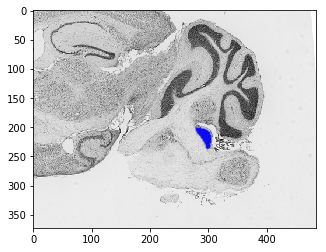

In [11]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
x_offset = -50
y_offset = -11
structure = 'DC'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Positive Patches:',len(valid_patch_indices)

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (float(x)) )
    y_raw.append( (float(y)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')

plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

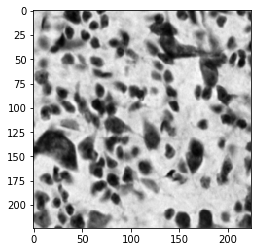

In [12]:

img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
index = 50
x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset*32
y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset*32

patch = img[y:y+224,x:x+224]


plt.imshow( patch, cmap='gray')

### Save patches to files

In [13]:
x_offset = -1600
y_offset = -352
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        for index in range(len(all_patch_locations[structure][section])):
            x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset
            y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset
            patch = img[y:y+224,x:x+224]
            filename=savepath+'/'+str(section)+'_'+str(index)+'.tif'
            cv2.imwrite(filename, patch)


mkdir: cannot create directory ‘/data/BstemAtlasDataBackup/ucsd_brain//CSHL_patches’: File exists
mkdir: cannot create directory ‘/data/BstemAtlasDataBackup/ucsd_brain//CSHL_patches/MD589’: File exists
Tz ALREADY EXIST
VCA ALREADY EXIST
7n ALREADY EXIST
DC ALREADY EXIST
5N ALREADY EXIST
3N ALREADY EXIST
Pn ALREADY EXIST
10N ALREADY EXIST
LC ALREADY EXIST
7N ALREADY EXIST
Amb ALREADY EXIST
12N ALREADY EXIST
RMC ALREADY EXIST
Sp5O ALREADY EXIST
Sp5I ALREADY EXIST
Sp5C ALREADY EXIST
VCP ALREADY EXIST
AP ALREADY EXIST
PBG ALREADY EXIST
LRt ALREADY EXIST
IC ALREADY EXIST
VLL ALREADY EXIST
4N ALREADY EXIST
SNC ALREADY EXIST
6N ALREADY EXIST
SNR ALREADY EXIST
SC ALREADY EXIST
RtTg ALREADY EXIST


## Negative patches

In [14]:
all_patch_locations = {}

for structure in all_structures: 
    structure=structure+'_surround_200um_noclass'
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ].tolist()
        all_patch_locations[structure][int(section)] = patch_coors

Number of Negative Patches: 629


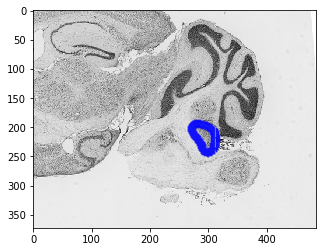

In [15]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
x_offset = -50
y_offset = -11
structure = 'DC'+'_surround_200um_noclass'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Negative Patches:',len(valid_patch_indices)

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (float(x)) )
    y_raw.append( (float(y)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')

plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

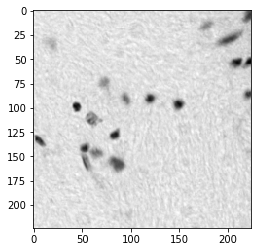

In [16]:
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
index = 20
x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset*32
y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset*32

patch = img[y:y+224,x:x+224]


plt.imshow( patch, cmap='gray')

In [ ]:
x_offset = -1600
y_offset = -352
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        for index in range(len(all_patch_locations[structure][section])):
            x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset
            y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset
            patch = img[y:y+224,x:x+224]
            filename=savepath+'/'+str(section)+'_'+str(index)+'.tif'
            cv2.imwrite(filename, patch)


In [17]:
! ls $ROOT_DIR/CHDL_patches

ls: cannot access '/data/BstemAtlasDataBackup/ucsd_brain//CHDL_patches': No such file or directory


In [18]:
%cwd

UsageError: Line magic function `%cwd` not found.


In [19]:
%pwd

u'/data/Github/MouseBrainAtlas_dev/src/learning'

In [2]:
%cd $ROOT_DIR/CSHL_patches/$stack

[Errno 2] No such file or directory: '$ROOT_DIR/CSHL_patches/$stack'
/data/Github/MouseBrainAtlas_dev/src/learning


In [1]:
%ls 

Patches_extract.ipynb
README.md*
a_learning_driver.ipynb*
a_train_and_test_classifier_performance_v4.py*
classifier_settings.csv*
compute_features_for_entire_stacks.ipynb*
dataset_settings.csv*
demo_detectors_patch_extractor.ipynb*
detector_settings.csv*
export_train_and_test_patches.ipynb*
identify_patch_class_based_on_labeling_v3_human_annotations.py*
training_utilities.py*


In [ ]:
from glob import glob
for dir in glob('*'):
    print dir